In [3]:
#installing the necessary package 
! pip install -q 'gwosc==0.5.4' 
#checking which version was installed
import gwosc
print(gwosc.__version__) 
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
! pip install matplotlib==3.1.3
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'

#packages:
import numpy
import pylab
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.filter import resample_to_delta_t, highpass
from pycbc import frame
from pycbc.psd import interpolate, inverse_spectrum_truncation


# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf

# -- for gwpy 
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
print(gwpy_strain)

0.5.4
r/local/lib/python3.7/dist-packages (from matplotlib==3.1.3) (2.8.2)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gwpy 2.1.3 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


--2022-02-14 22:01:16--  https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025842 (3.8M)
Saving to: ‘challenge2.gwf.1’

challenge2.gwf.1    100%[===================>]   3.84M  6.12MB/s    in 0.6s    

2022-02-14 22:01:17 (6.12 MB/s) - ‘challenge2.gwf.1’ saved [4025842/4025842]

TimeSeries([ 8.75332715e-22,  1.27597248e-22,  1.88838802e-22,
            ..., -1.91886478e-23, -2.10989354e-22,
             2.30287965e-22]
           unit: ct,
           t0: -64.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE2,
           channel: H1:CHALLENGE2)


I decided to do a q transfrom to find the approximate time of the merger. A q transfrom is similar to a fast fourier transform, it is the IFFT of some FFTed data plus a frequency shift times a windowing function

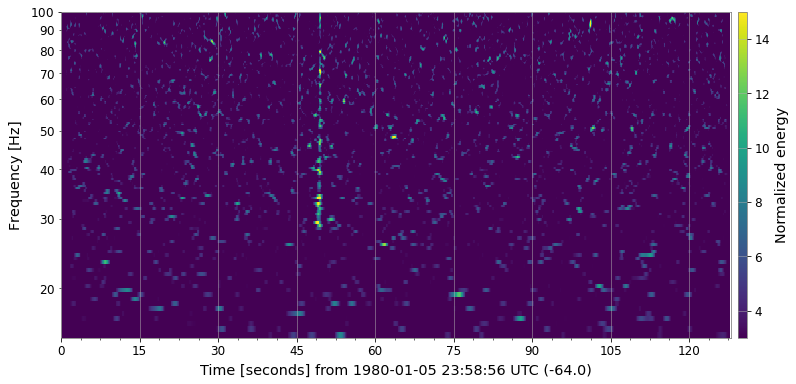

In [27]:
#Exercise 1
#Creating a Q transform to find the time of the merger
hq = gwpy_strain.q_transform(frange=(15, 100), qrange=(100, 300))
plot = hq.plot() #plotting the q-transform 
ax = plot.gca() #defining the axis
ax.set_yscale('log')  #scaling the y axis as a logarithmic 
plot.add_colorbar(cmap='viridis', label='Normalized energy') #adding a colorbar with the label 
plot.colorbars[0].mappable.set_clim(3, 15) 


In [28]:
print('As visible from the last plot, the time of the merger is at around 64 seconds')

As visible from the last plot, the time of the merger is at around 64 seconds


In [59]:
#Question 2
#Creating a template with m1 = m2 =  30 
#specifying the sample rate
#this is not a particularly high value, to make the sampling go faster
sample_rate = 1024 # samples per second
#this is the variable for the approximant, which is a paramterized wavefrom family
apx = 'SEOBNRv4_opt'
#variable for the masses
m = 30 #solar masses


Text(0, 0.5, 'Normalized amplitude')

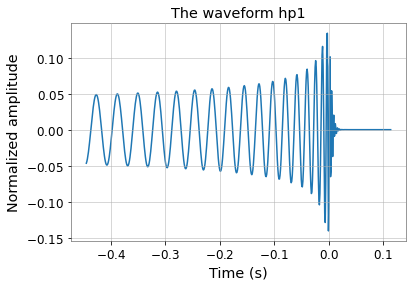

In [60]:
#creating the template using get_td_waveform with the masses as determined by the variable m, the approximant as determined by the variabole apx 
#and a lower bound for the frequency of 25
hp1, _ = get_td_waveform(approximant=apx,
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

hp1 = hp1 / max(numpy.correlate(hp1, hp1, mode='full'))**0.5
#plot the templater
pylab.figure()
pylab.title("The waveform hp1") # set a title
pylab.plot(hp1.sample_times, hp1)
pylab.xlabel('Time (s)') #set axes labels
pylab.ylabel('Normalized amplitude')


Delta_t of the data : 0.000244140625 s
Sample rate of the data:  4096.0 1 / s
Nyquist frequency:  2048.0 1 / s


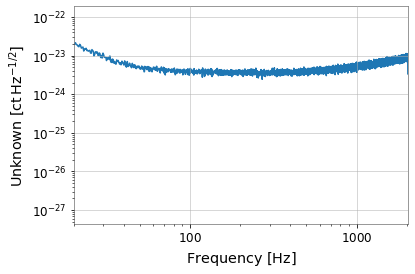

In [61]:
#Question 3
#creating the power spectral density
psd = gwpy_strain.asd(fftlength=4, method="median") #asd uses welch's method to combine overlapping, windowed pieces of data
plot = psd.plot() 
ax = plot.gca()
#scaling the axis so they are logarithmic, as there are very high values
ax.set_xscale('log')
ax.set_yscale('log')

#finding nyquist frequency: defined as 1/2 of the sample rate

sample_rate = 1.0/gwpy_strain.dt
nyq_freq = sample_rate*0.5
print("Delta_t of the data :", gwpy_strain.dt)
print("Sample rate of the data: ", sample_rate)
print("Nyquist frequency: ", nyq_freq)

ax.set_xlim(20, 2048) #defining the limits for the x-axis: 20 to the nyquist frequency which was found in the lines above

plot.show(warn=False)

In [50]:
##Question 4
#creating matched filtering

Matched filtering is a process in which a template is compared to a signal and the signal to noise ratio (SNR) is calculated for every time step. This means every part of th e template gets moved over every part of the signal. If there is a SNR over 8, a signal is found.

In [62]:
#Preconditioning the data
# Remove the low frequency content and downsample the data to 2048Hz
pycbc_strain = highpass(pycbc_strain, 15.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)
#removing 2 sec from beginning and end
condition = pycbc_strain.crop(2, 2)

In [63]:
# Estimating the power spectral density again, this time with the preconditioned data to make the SNR calculation easier

# We use 4 second samples of our time series in Welch method, whicha s mentioned erlaier takes pieces of data and combines then
psd = condition.psd(4)
#After having created our new psd, it is necessary to interpolate it so it properly matches our data and to limit the filter length of 1/PSD
 
psd = interpolate(psd, condition.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
#As we have have highpassed our frequency with 15 and thus excluded frequencies below that, our low frequency cut off is at 15 Hz.
psd = inverse_spectrum_truncation(psd, int(4 * condition.sample_rate),
                                  low_frequency_cutoff=15)

In [64]:
#now we need to also redo the creation of the template, as we need to have the delta t match our new, preconditioned data, described by the variable condition

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=condition.delta_t,
                    f_lower=25)

# Now we have to resize the vector to match our data
hp.resize(len(condition))

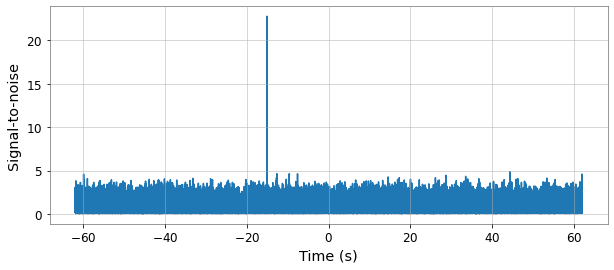

We found a signal at -15.078125s with SNR 22.76293737345781


In [66]:
#this is the final step: calculating the SNR
# To do this, the template (hp) will be cross correlated with the data (condition). The psd is the psd and the low frequency cut off is 20.
snr = matched_filter(hp, condition, psd=psd, low_frequency_cutoff=20)
pylab.figure(figsize=[10, 4]) #defining the sizes of the plot
pylab.plot(snr.sample_times, abs(snr)) #plotting the snar value against the time
pylab.ylabel('Signal-to-noise') #naming the y axis
pylab.xlabel('Time (s)') #naming the x axis
pylab.show() #printing the plot

peak = abs(snr).numpy().argmax() # defining the paek as the maximal snr value in this data 
snrp = snr[peak] #the value for the snr at the peak 
time = snr.sample_times[peak] #time at which the peak is found

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))